<h1>Alexnet CNN</h1>

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<h2>Train & Test Data Loaders</h2>

In [8]:
import torchvision
test_path = '/content/Testing'
train_path = '/content/Training'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




train_dataset = datasets.GTSRB(
        root='/content', split='train',
        download=True, transform=preprocess,
    )

test_dataset = datasets.GTSRB(
        root='/content', split='test',
        download=True, transform=preprocess,
    )


train_dataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True,  num_workers=2)
print('Train',len(train_dataset))

print('TEST',len(test_dataset))
test_dataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True,  num_workers=2)


Train 26640
TEST 12630


Hyper Parameters

In [ ]:
num_classes = 43
num_epochs = 20
batch_size = 256
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    model.cuda()

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [ ]:
import time
start_time = time.time()
total_step = len(train_dataLoader)
accuracy_list = []

steps_list = []
train_loss = []
train_accuracy = []
train_loss = []

for epoch in range(num_epochs):
  for i, data in enumerate(train_dataLoader):
    images, labels = data[0].to(device), data[1].to(device)

    #Forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    #Backpropogation and Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Train Accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data,1)

    correct = (predicted == labels).sum().item()
    
    steps = i + 1
    accuracy = (correct / total) * 100
    accuracy_list.append(accuracy)
    steps_list.append(steps)
    train_loss.append(loss.item())
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, steps, total_step, loss.item(),
          accuracy))
    
    

print("######## Training Finished in {} seconds ###########".format(time.time()-start_time))
print("Accuracy List: ",accuracy_list, "Steps List: ",steps_list)

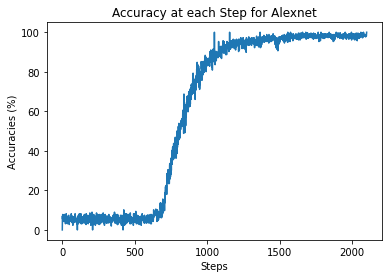

In [12]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Step for Alexnet")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(accuracy_list)

pyplot.show()

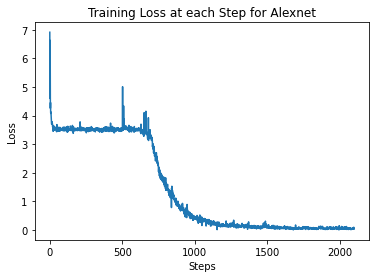

In [13]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Training Loss at each Step for Alexnet")
pyplot.xlabel("Steps")
pyplot.ylabel("Loss")
pyplot.plot(train_loss)

pyplot.show()

In [19]:
from torch.autograd import Variable
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
import torch.nn.functional as F

pred_y = []
lable_given_img = []

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
       
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)

        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        #print(pred)
        total += len(data)

        for i in pred :
          pred_y.append(i.abs().tolist())
        for i in target :
          lable_given_img.append(i.abs().tolist())
        correct += (pred == target).sum()

    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))
    print('correct:',correct)

In [20]:
for epoch in range(1):
  evaluate(test_dataLoader)

<ipython-input-19-d659eb39f309>:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Average Validation loss: 0.73420	Accuracy: 88.32937622070312 %
correct: tensor(11156, device='cuda:0')


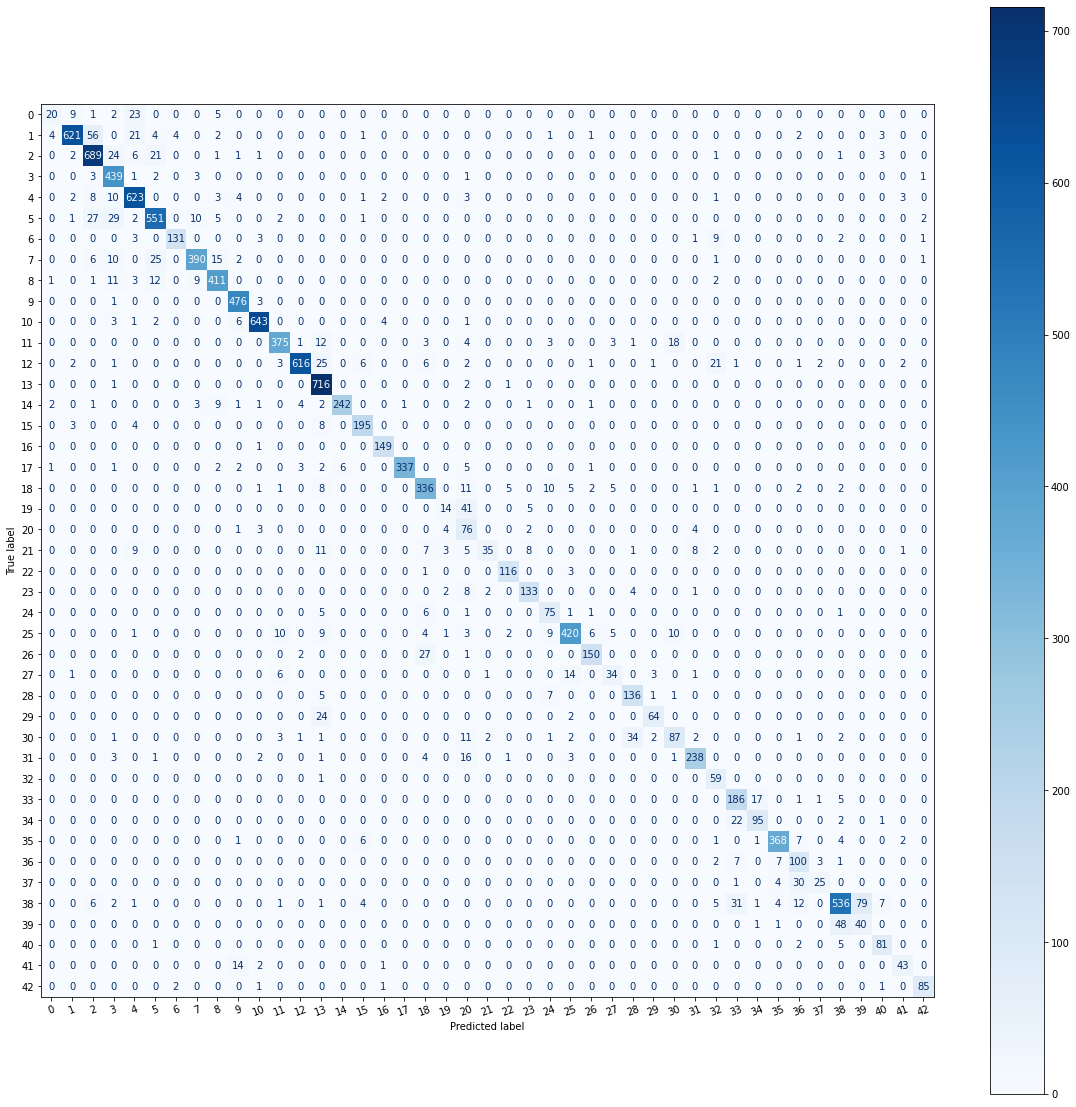

In [22]:
# Print confusion matrix
import matplotlib.pyplot as pyplot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, num_classes)
plot_confusion_matrix(lable_given_img, pred_y, labels_arr)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(lable_given_img, pred_y))

              precision    recall  f1-score   support

           0       0.71      0.33      0.45        60
           1       0.97      0.86      0.91       720
           2       0.86      0.92      0.89       750
           3       0.82      0.98      0.89       450
           4       0.89      0.94      0.92       660
           5       0.89      0.87      0.88       630
           6       0.96      0.87      0.91       150
           7       0.94      0.87      0.90       450
           8       0.91      0.91      0.91       450
           9       0.94      0.99      0.96       480
          10       0.97      0.97      0.97       660
          11       0.94      0.89      0.91       420
          12       0.98      0.89      0.94       690
          13       0.86      0.99      0.92       720
          14       0.98      0.90      0.93       270
          15       0.91      0.93      0.92       210
          16       0.95      0.99      0.97       150
          17       1.00    

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in test_dataLoader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [24]:
PATH = '/content/Alex_GTSRB.pt'
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'accuracy': accuracy_list
            }, PATH)